# 5. PREPROCESSING

# Import Libraries

In [24]:
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from memory_profiler import memory_usage
import time
import tracemalloc
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (10,6)

# Define column names

In [115]:
columns = (['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
           'attack', 'level'])

# Load datasets

In [116]:
df_train = pd.read_csv("../../Datasets/NSL-KDD/KDDTrain+.txt", header=None, names=columns)
df_test = pd.read_csv("../../Datasets/NSL-KDD/KDDTest+.txt",header=None,names=columns)

In [117]:
df_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.170,0.030,0.170,0.000,0.000,0.000,0.050,0.000,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.060,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.960,0.010,0.010,0.000,0.000,0.000,0.000,0.000,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.120,0.060,0.000,0.000,0.720,0.000,0.010,0.000,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.030,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20


In [118]:
df_test.columns = columns  # Assign column names to the dataset

# Drop duplicate rows and check for missing values

In [119]:
print(f"Duplicate rows in training set: {df_train.duplicated().sum()}")
print(f"Duplicate rows in test set: {df_test.duplicated().sum()}")

Duplicate rows in training set: 0
Duplicate rows in test set: 0


In [120]:
print("Missing values per column:")
print(df_train.isnull().sum())

Missing values per column:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate   

# Convert attack labels to binary (normal/malicious)

In [121]:
df_train["binary_attack"] = df_train.attack.map(lambda a: "normal" if a == 'normal' else "malicious")
df_test["binary_attack"] = df_test.attack.map(lambda a: "normal" if a == 'normal' else "malicious")

# Drop original attack column

In [122]:
df_train.drop('attack', axis=1, inplace=True)
df_test.drop('attack', axis=1, inplace=True)

# ✅ Track System Metrics Before Processing

In [123]:
start_time = time.time()
cpu_before = psutil.cpu_percent(interval=None)
mem_before = psutil.virtual_memory().used
disk_before = psutil.disk_io_counters().write_bytes + psutil.disk_io_counters().read_bytes

# Label encoding categorical features

In [124]:
df_train.select_dtypes(['object']).columns

Index(['protocol_type', 'service', 'flag', 'binary_attack'], dtype='object')

<!-- # Parallelized Label Encoding -->

In [125]:
clm = ['protocol_type', 'service', 'flag', 'binary_attack']
le = preprocessing.LabelEncoder()

for x in clm:
    df_train[x] = le.fit_transform(df_train[x])
    df_test[x] = le.fit_transform(df_test[x])
    

In [126]:
# Transform the categorical labels into binary format.
lb = LabelBinarizer()

# Transform the 'label' column to binary format.
df_train['binary_attack'] = lb.fit_transform(df_train['binary_attack'])

df_train


# Transform the 'label' column to binary format.
df_test['binary_attack'] = lb.fit_transform(df_test['binary_attack'])

df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,binary_attack
0,0,1,45,1,0,0,0,0,0,0,...,0.040,0.060,0.000,0.000,0.000,0.000,1.000,1.000,21,0
1,0,1,45,1,0,0,0,0,0,0,...,0.000,0.060,0.000,0.000,0.000,0.000,1.000,1.000,21,0
2,2,1,19,9,12983,0,0,0,0,0,...,0.610,0.040,0.610,0.020,0.000,0.000,0.000,0.000,21,1
3,0,0,13,9,20,0,0,0,0,0,...,1.000,0.000,1.000,0.280,0.000,0.000,0.000,0.000,15,0
4,1,1,55,2,0,15,0,0,0,0,...,0.310,0.170,0.030,0.020,0.000,0.000,0.830,0.710,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,0.720,0.060,0.010,0.010,0.010,0.000,0.000,0.000,21,1
22540,0,1,22,9,317,938,0,0,0,0,...,1.000,0.000,0.010,0.010,0.010,0.000,0.000,0.000,21,1
22541,0,1,22,9,54540,8314,0,0,0,2,...,1.000,0.000,0.000,0.000,0.000,0.000,0.070,0.070,15,0
22542,0,2,11,9,42,42,0,0,0,0,...,0.990,0.010,0.000,0.000,0.000,0.000,0.000,0.000,21,1


# ✅ Track System Metrics After Processing

In [127]:
# 🏆 End Profiling
cpu_after = psutil.cpu_percent(interval=None)
mem_after = psutil.virtual_memory().used
disk_after = psutil.disk_io_counters().write_bytes + psutil.disk_io_counters().read_bytes
end_time = time.time()

In [128]:
# ✅ Performance Metrics
execution_time = end_time - start_time
cpu_usage_change = cpu_after - cpu_before
memory_used = (mem_after - mem_before) / (1024 ** 2)  # Convert bytes to MB
disk_io_used = (disk_after - disk_before) / (1024 ** 2)  # Convert bytes to MB

# ✅ Memory Usage Per Column
mem_usage = df_train.memory_usage(deep=True).sum() / (1024 ** 2)

# Print Computational Overhead Results

In [129]:
# 🏆 Print Performance Report
print(f"🚀 **Optimized Computational Overhead Report** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")
print(f"📂 **Memory Usage Per Column (Train Set):** {mem_usage:.2f} MB")

🚀 **Optimized Computational Overhead Report** 🚀
⏳ **Execution Time:** 2.4361 seconds
🔥 **CPU Usage Change:** -2.20%
💾 **Disk I/O Usage:** 3.23 MB
📊 **Peak Memory Usage:** -14.73 MB
📂 **Memory Usage Per Column (Train Set):** 41.33 MB


## 5.2 TRAIN-TEST-SPLIT

In [130]:
X_train = df_train.drop(['binary_attack', 'level'], axis=1)
y_train = df_train['binary_attack']
X_test = df_test.drop(['binary_attack', 'level'], axis=1)
y_test = df_test['binary_attack']

In [131]:
# Transform the 'label' column to binary format.
# df_test['binary_attack'] = lb.fit_transform(df_test['binary_attack'])

# df_test

# Feature Selection (Mutual Information)

<Axes: title={'center': 'Feature Importance'}>

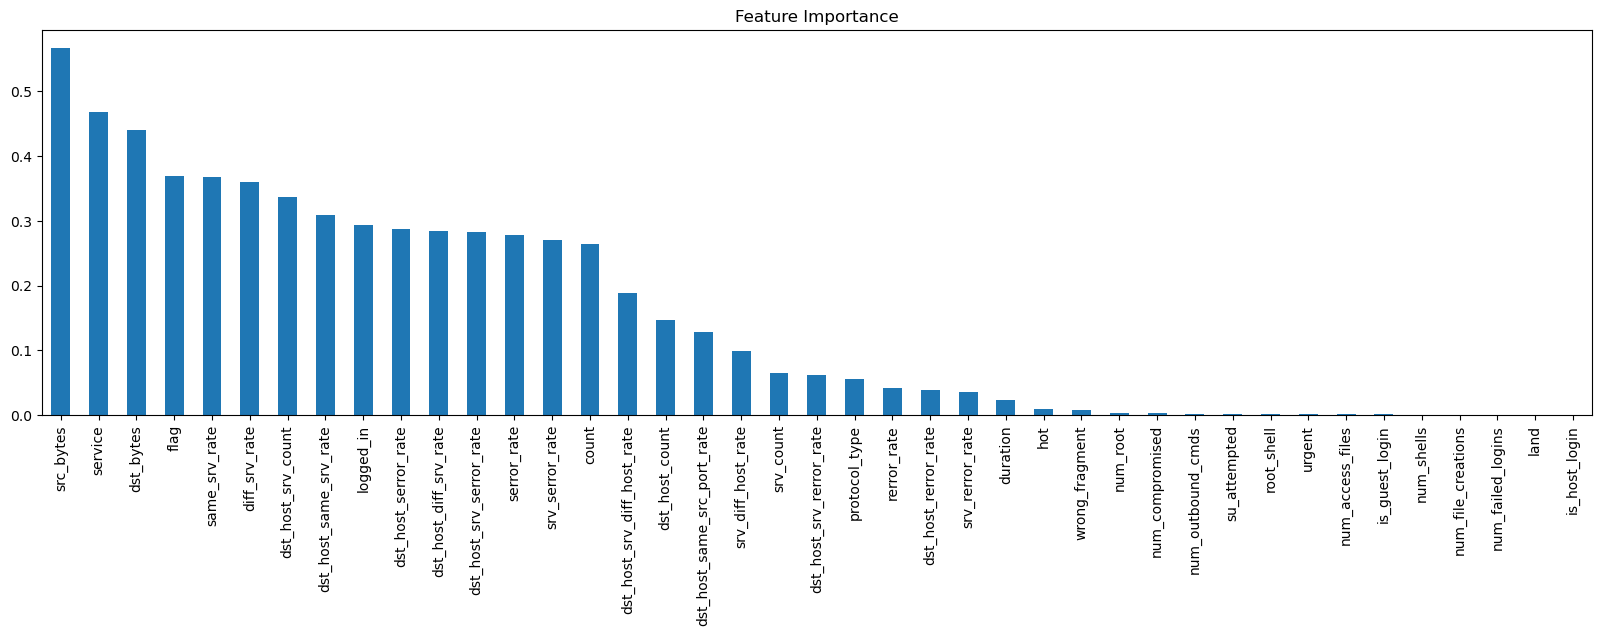

In [132]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info_series = pd.Series(mutual_info, index=X_train.columns)
mutual_info_series.sort_values(ascending=False).plot.bar(figsize=(20, 5), title="Feature Importance")

# Select top 15 features

In [135]:
top_features = mutual_info_series.sort_values(ascending=False).head(15).index.tolist()

# Hardcoded features to always include
hardcoded_features = ['duration', 'num_failed_logins', 'hot']

# Ensure these features are included in the final selection
final_features = list(dict.fromkeys(final_features))
final_features = final_features[:18]

X_train = X_train[final_features]
X_test = X_test[final_features]

We will continue our model with top 15 features, because dataset is big enough

In [137]:
final_features

['duration',
 'num_failed_logins',
 'hot',
 'src_bytes',
 'service',
 'dst_bytes',
 'flag',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'logged_in',
 'dst_host_serror_rate',
 'dst_host_diff_srv_rate',
 'dst_host_srv_serror_rate',
 'serror_rate',
 'srv_serror_rate',
 'count']

## 5.5 Scaling

In [138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Saving Train and Test Datasets

In [139]:
# Save training data
df_train.to_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv', index=False)

# Save testing data
df_test.to_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv', index=False)

print('Preprocessing complete. datasets saved to CSV files.')

Preprocessing complete. datasets saved to CSV files.


# -------------------------------
# SCALABILITY TEST (Execution Time vs. Dataset Size)
# -------------------------------

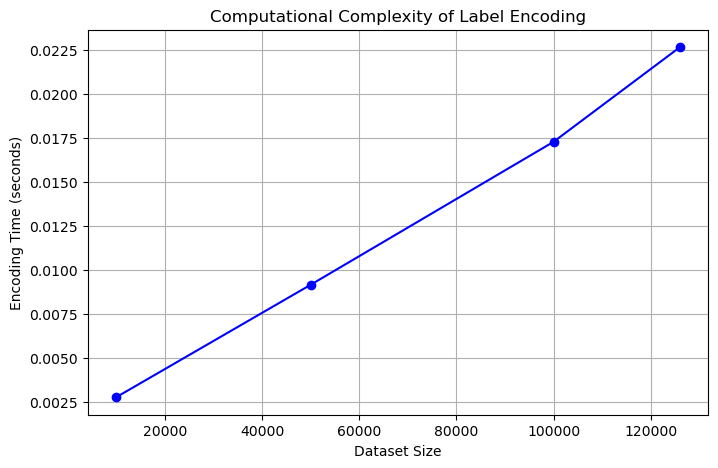

In [140]:
sizes = [10_000, 50_000, 100_000, len(df_train)]
encoding_times = []

for size in sizes:
    df_sample = df_train.sample(n=size, random_state=42).copy()
    start_time = time.time()
    for x in clm:
        df_sample[x] = le.fit_transform(df_sample[x])
    encoding_times.append(time.time() - start_time)

# Plot the Computational Complexity of Label Encoding
plt.figure(figsize=(8, 5))
plt.plot(sizes, encoding_times, marker='o', color='b', linestyle='-')
plt.xlabel("Dataset Size")
plt.ylabel("Encoding Time (seconds)")
plt.title("Computational Complexity of Label Encoding")
plt.grid()
plt.show()